In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
def file2table(file):
    emp=[]
    data = pd.read_csv(file.open(), header = None)
    for a in range(1,len(data)):
        tmp=[a for a in data.iloc[a][0].split(' ') if a != '']
        emp.append(tmp)
    emp=pd.DataFrame(emp)
    return emp

In [3]:
def table2matrix(tablaRaw):
    #poniendo todo en columnas
    x=[]
    y=[]
    for a in range(len(tablaRaw.columns)):
        if a % 2 == 0:
            # Even column index, add data points to x
            x.append(tablaRaw.iloc[:, a].values.astype(float))
        else:
            # Odd column index, add data points to y
            y.append(tablaRaw.iloc[:, a].values.astype(float))
    return x, y

In [ ]:
def spikeDetector(vouts):
    #retorna true si el voltaje de salida supera 1.6V
    #el vector de salida es de la misma longitud que el de la entrada
    #obteniendo un arreglo con los spikes por cada simulacion
    spikes=[]      
    for a in vouts:
        result = [True if a >= 1.7 else False for a in a]
        index=[]
        for b in range(len(result)-1):
            if result[b] == 1 and result[b+1] == 0:
                index.append(True)
            else:
                index.append(False)
        spikes.append(index)
    return spikes

In [ ]:
def obtainFrequencies(x, y, spikes):
    #obteniendo el tiempo entre spikes y metiendolo en un arreglo
    vals=[0]
    for a in range(len(y)):
        mask=spikes[a]
        vari=x[a][:-1][mask]
        #print('Time between spikes for the {}th simulation is {}'.format(a+1,vari))
        if len(vari)>=2:
            tm_diff=vari[-1] - vari[-2]
            vals.append(1/tm_diff)
            #print(f"Spike frequency of the impulses is {1/tm_diff}")
        else:
            #print('No spikes detected')
            vals.append(vals[-1])
    vals.pop(0)
    return vals

In [6]:
def getRiobase(Fout, Iin_sweep):
    #recibe un vector con la frecuencia de disparo de salida de una neurona
    #devuelve el valor de corriente riobase
    riobase = 0
    for i in range(len(Fout)):
        if (Fout[i]>0):
            riobase = Iin_sweep[i]
            break
    return riobase

In [7]:
def getLeakCurrentFromNameFile(file):
    #recibe el archivo y retorna el numero flotante que representa la corriente de fuga
    tokens = file.name.split("_")
    leakCurrent = float(tokens[1])
    return leakCurrent
    

Text(0.5, 1.0, 'Tuning Curves for different leakeage currents')

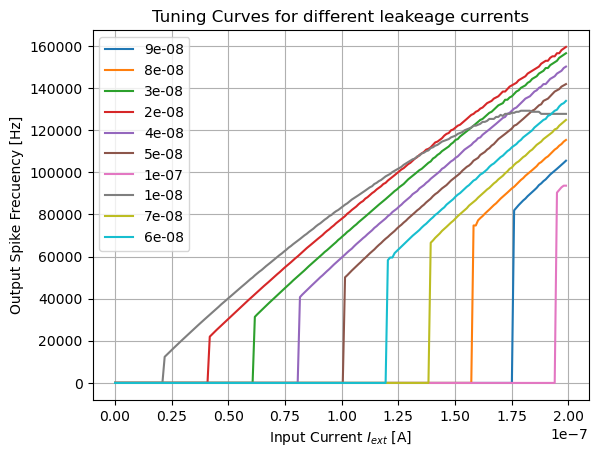

In [8]:
files = [f for f in pathlib.Path().glob("sims/*.txt")]
fig, ax = plt.subplots(1)
list_riobases = []
Iext_max = 200e-9
Ilk_max = 100e-9

for file in files:
    tablaFile = file2table(file)
    x , y = table2matrix(tablaFile)
    y_spikes = spikeDetector(y)
    fout_sweep = obtainFrequencies(x, y, y_spikes)
    Iext_sweep = np.arange(0, Iext_max, Iext_max/(len(y)))  #generando un vector de 0-2eee-9V para el barrido de corriente
    leakCurrent = getLeakCurrentFromNameFile(file)
    list_riobases.append((leakCurrent, getRiobase(fout_sweep, Iext_sweep)))
    ax.plot(Iext_sweep, fout_sweep,label = leakCurrent)

ax.legend()
ax.set_xlabel("Input Current $I_{ext}$ [A]")
ax.set_ylabel("Output Spike Frecuency [Hz]")
ax.grid()
ax.set_title("Tuning Curves for different leakeage currents")



In [9]:
dtype = [('Ilk', float), ('Riobase', float)]
list_riobases_np = np.array(list_riobases, dtype=dtype)
list_riobases_ordered = np.sort(list_riobases_np, order='Ilk')

Text(0.5, 1.0, 'Riobase as function of the leakage current')

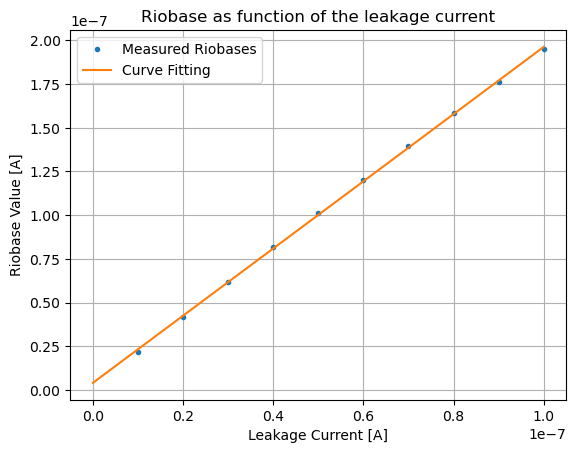

In [10]:
z = np.polyfit(list_riobases_ordered['Ilk'], list_riobases_ordered['Riobase'], 1)
p = np.poly1d(z)
z_num = np.arange(0,Ilk_max, Ilk_max/50)
p_num = p(z_num)
fig, ax = plt.subplots(1)
ax.plot(list_riobases_ordered['Ilk'], list_riobases_ordered['Riobase'],'.', label="Measured Riobases")
ax.plot(z_num, p_num, label="Curve Fitting")
ax.legend()
ax.set_xlabel("Leakage Current [A]")
ax.set_ylabel("Riobase Value [A]")
ax.grid()
ax.set_title("Riobase as function of the leakage current")

In [11]:
p

poly1d([1.92311171e+00, 3.98009950e-09])